In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

# astropy
from astropy import units as u
from astropy import constants

# density estimation
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

import emcee
#import pymc3
import corner

import dynesty

import sklearn
from sklearn import manifold
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

# Regression
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.gaussian_process import GaussianProcessRegressor

# Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Regularization
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

## Supernova distances and redshifts (part 2)

(35.0, 50.0)

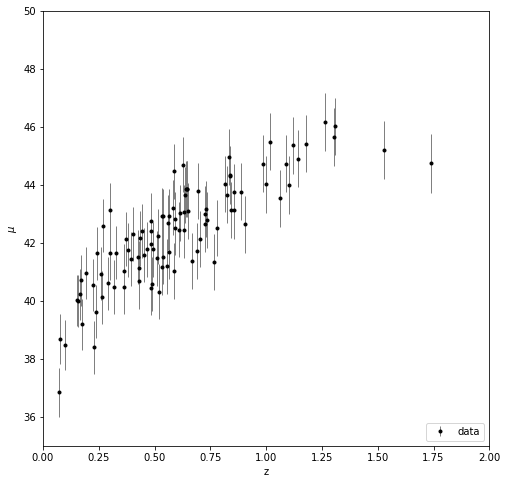

In [3]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

fig = plt.figure(figsize=(8,8))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingrediente in getting a good GPR fit is the choice of the kernel and its parameters.
- Check out what's available in the `kernels` submodule of [sklearn.gaussian_process](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process)
- *Hint*. Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

*Note*. We have time constraints, so feel free to tweak the hyperparameters manually while in class. But, of course, a publication-quality result will require a cross-validation analysis. (Do this at home before the exam?)

In [4]:
# put the data in the correct format for sklearn:

X = z_sample[:,np.newaxis]
y = mu_sample[:,np.newaxis]
dy = dmu

In [5]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF,ConstantKernel

#### Cross validation to determine the best kernel

In [6]:
def error_func(y_true, y_m,sigma_y):
    N = len(y_true)
    return np.sqrt(1/N * np.sum((y_true-y_m)**2/sigma_y**2)) 

def cross_validation(X,y,model,split_method):
    "computes and returns the cross validation error and the training error, given the datasets and the model to validate"
    
    split = split_method # sample splitting
    
    err_train_i = []
    err_cv_i = []
    
    # iterating over the n_splits
    for train, test in split.split(X):
        
        # define the model given the splitted data
        model.fit(X[train],y[train],dmu[train]) 
        
        #define the variables to compute the errors
        y_train = model.predict(X[train])
        y_true_train = y[train]
        
        y_cv = model.predict(X[test])
        y_true_cv = y[test]
    
        # compute the errors on the training and cross-validation set for a given set
        err_train_i.append(error_func(y_true_train,y_train)) # compute the error on the training set
        err_cv_i.append(error_func(y_true_cv,y_cv)) # compute the error on the validation set
        
    '''    
    err_train = np.sqrt(np.sum(err2_train_i))
    err_cv = np.sqrt(np.sum(err2_cv_i))
    '''
    
    err_train = np.mean(err_train_i)
    err_cv = np.mean(err_cv_i)
    
    return err_train, err_cv

#### Constant Kernel + RBF: CV on constant and lenght scale

In [7]:
ls_range = np.linspace(0.01,2,10)
const_range = np.linspace(1,20,10)

err_cv_sum = np.empty([len(const_range),len(ls_range)])
err_train_sum = np.empty([len(const_range),len(ls_range)])

for c,j in zip(const_range,np.arange(0,len(const_range))):
    for ls,i in zip(ls_range,np.arange(0,len(ls_range))):
        # summed kernel
        # constant kernel added to RBF modifies the mean of the Gaussian process.
        kernel = ConstantKernel(c,constant_value_bounds='fixed') + RBF(length_scale=ls,length_scale_bounds='fixed') 
        # cross validation
        loo = LeaveOneOut() # sample splitting
    
        err_train_i = []
        err_cv_i = []
    
        # iterating over the n_splits
        for train, test in loo.split(X):
            model = GaussianProcessRegressor(kernel=kernel,alpha=(dmu[train])**2)
            
            # define the model given the splitted data
            model.fit(X[train],y[train]) 
        
            #define the variables to compute the errors
            y_train = model.predict(X[train])
            y_cv = model.predict(X[test])
            y_true_train = y[train]
            y_true_cv = y[test]
            dy_train = dy[train]
            dy_test = dy[test]
        
            # compute the errors on the training and cross-validation set for a given set
            err_train_i.append(error_func(y_true_train,y_train,dy_train)) # take the square to sum
            err_cv_i.append(error_func(y_true_cv,y_cv,dy_test)) # take the square to sum
        
        err_train_sum[j,i] = np.mean(err_train_i)
        err_cv_sum[j,i] = np.mean(err_cv_i)
    

Text(0.5, 1.0, 'Training error 2D distribution Const+RBF kernel')

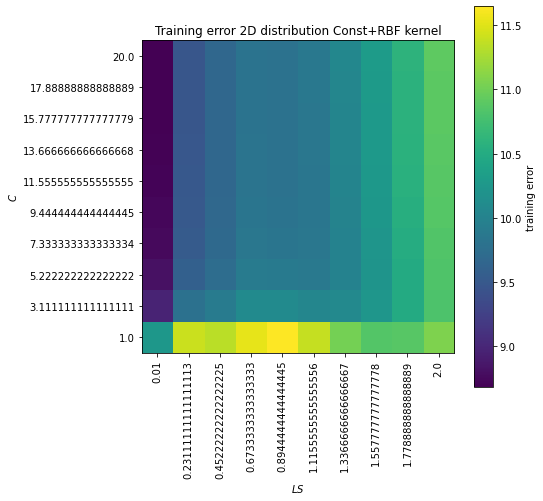

In [8]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_train_sum,origin='lower')
plt.colorbar(label='training error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('Training error 2D distribution Const+RBF kernel')

Text(0.5, 1.0, 'CV error 2D distribution Const+RBF kernel')

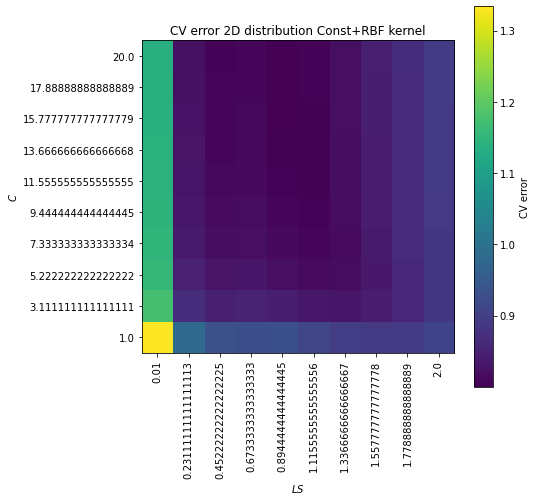

In [9]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_cv_sum,origin='lower')
plt.colorbar(label='CV error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('CV error 2D distribution Const+RBF kernel')

In [10]:
min_C_idx,min_ls_idx = np.where(err_cv_sum == np.min(err_cv_sum))

best_C_sum = const_range[min_C_idx[0]]
best_ls_sum = ls_range[min_ls_idx[0]]

print('best C:',best_C_sum)
print('best ls:',best_ls_sum)

best C: 20.0
best ls: 0.8944444444444445


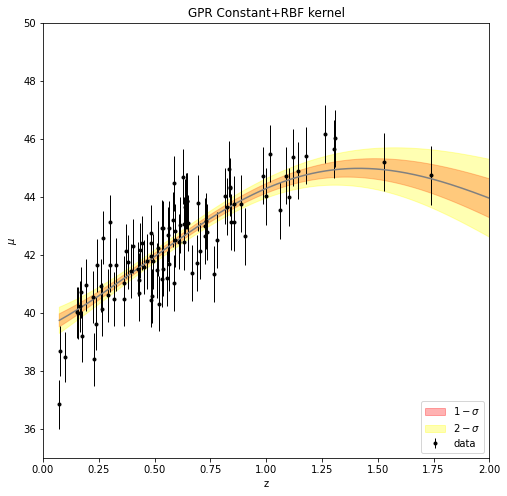

In [11]:
best_kernel_sum = ConstantKernel(best_C_sum,constant_value_bounds='fixed') + RBF(best_ls_sum, length_scale_bounds='fixed')
gp_best_sum = GaussianProcessRegressor(kernel=best_kernel_sum,alpha=(dmu)**2)
gp_best_sum.fit(X,y)

X_grid = np.linspace(z_sample.min(),z_sample.max()+1,1000)[:,np.newaxis]

y_pred, dy_pred = gp_best_sum.predict(X_grid, return_std=True)

fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0], y_pred[:,0], '-', color='gray')

plt.fill_between(X_grid[:,0], y_pred[:,0]-dy_pred, y_pred[:,0]+dy_pred, 
                color='red', alpha=0.3,label='$1-\sigma$')

plt.fill_between(X_grid[:,0], y_pred[:,0]-2*dy_pred, y_pred[:,0]+2*dy_pred, 
                color='yellow', alpha=0.3,label='$2-\sigma$')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('GPR Constant+RBF kernel')
plt.xlim(0,2)
plt.ylim(35,50);

#### Constant Kernel * RBF: CV on constant and length scale

In [12]:
err_cv_prod = np.empty([len(const_range),len(ls_range)])
err_train_prod = np.empty([len(const_range),len(ls_range)])

for c,j in zip(const_range,np.arange(0,len(const_range))):
    for ls,i in zip(ls_range,np.arange(0,len(ls_range))):
        # product kernel
        # constant kernel multiplied to RBF scales the magnitude of the other factor (kernel)
        kernel = ConstantKernel(c,constant_value_bounds='fixed') * RBF(length_scale=ls,length_scale_bounds='fixed') 
        # cross validation
        loo = LeaveOneOut() # sample splitting
    
        err_train_i = []
        err_cv_i = []
    
        # iterating over the n_splits
        for train, test in loo.split(X):
            model = GaussianProcessRegressor(kernel=kernel,alpha=(dmu[train])**2)
            
            # define the model given the splitted data
            model.fit(X[train],y[train]) 
        
            #define the variables to compute the errors
            y_train = model.predict(X[train])
            y_cv = model.predict(X[test])
            y_true_train = y[train]
            y_true_cv = y[test]
            dy_train = dy[train]
            dy_test = dy[test]
        
            # compute the errors on the training and cross-validation set for a given set
            err_train_i.append(error_func(y_true_train,y_train,dy_train)) # take the square to sum
            err_cv_i.append(error_func(y_true_cv,y_cv,dy_test)) # take the square to sum
        
        err_train_prod[j,i] = np.mean(err_train_i)
        err_cv_prod[j,i] = np.mean(err_cv_i)

Text(0.5, 1.0, 'Training error 2D distribution Const*RBF kernel')

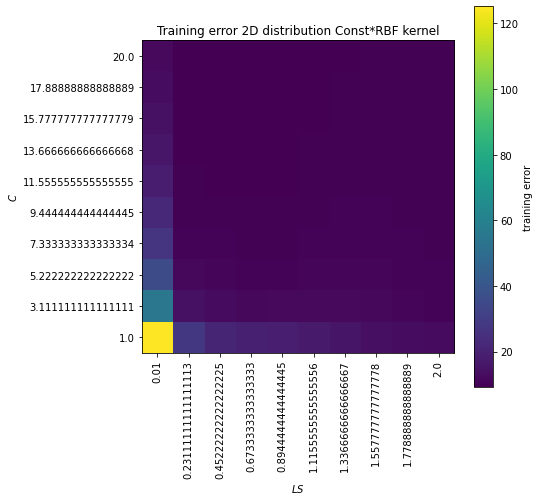

In [13]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_train_prod,origin='lower')
plt.colorbar(label='training error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('Training error 2D distribution Const*RBF kernel')

Text(0.5, 1.0, 'CV error 2D distribution Const*RBF kernel')

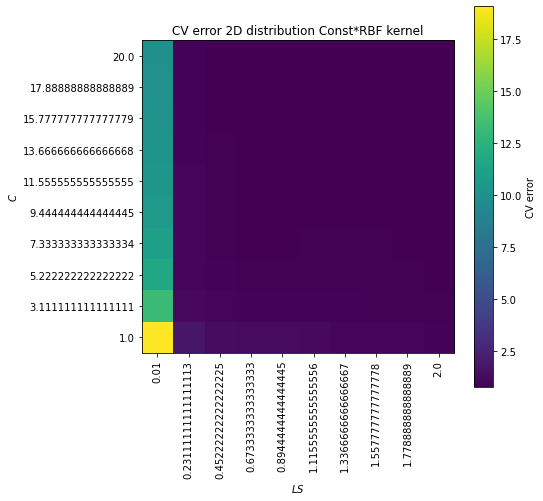

In [14]:
fig = plt.figure(figsize=(7,7))

plt.imshow(err_cv_prod,origin='lower')
plt.colorbar(label='CV error')
plt.ylabel(r'$C$')
plt.xlabel(r'$LS$')
#plt.xticks(mu_vec[::10]);

plt.yticks(np.arange(0,len(const_range)), const_range)
plt.xticks(np.arange(0,len(ls_range)), ls_range,rotation='vertical')
plt.title('CV error 2D distribution Const*RBF kernel')

In [15]:
min_C_idx,min_ls_idx = np.where(err_cv_prod == np.min(err_cv_prod))

best_C_prod = const_range[min_C_idx[0]]
best_ls_prod = ls_range[min_ls_idx[0]]

print('best C:',best_C_prod)
print('best ls:',best_ls_prod)

best C: 20.0
best ls: 0.8944444444444445


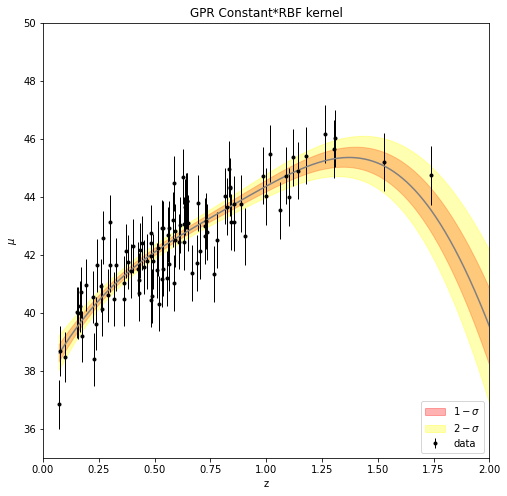

In [16]:
best_kernel_prod = ConstantKernel(best_C_prod,constant_value_bounds='fixed') * RBF(best_ls_prod, length_scale_bounds='fixed')
gp_best_prod = GaussianProcessRegressor(kernel=best_kernel_prod,alpha=(dmu)**2)
gp_best_prod.fit(X,y)

X_grid = np.linspace(z_sample.min(),z_sample.max()+1,1000)[:,np.newaxis]

y_pred, dy_pred = gp_best_prod.predict(X_grid, return_std=True)

fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0], y_pred[:,0], '-', color='gray')

plt.fill_between(X_grid[:,0], y_pred[:,0]-dy_pred, y_pred[:,0]+dy_pred, 
                color='red', alpha=0.3,label='$1-\sigma$')

plt.fill_between(X_grid[:,0], y_pred[:,0]-2*dy_pred, y_pred[:,0]+2*dy_pred, 
                color='yellow', alpha=0.3,label='$2-\sigma$')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('GPR Constant*RBF kernel')
plt.xlim(0,2)
plt.ylim(35,50);

We now have a suite of *data-drive predictive models* for our supernova dataset. That is: we can faithfully predict how a future redshift/distance measurement will look like given the current sample.

This is already great and these kind of tools are immensely useful in a variety of contexts (also involving a lot of money: suppose you want to predict how much a give financial asset will perform on tomorrow's stock market... You  might not really care about expressing the underlying financial model in simple terms, as long as your investments are profitable).

For the case of supernovae, however, we have do have physical theory which is $\Lambda$CDM.

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $\sigma$. *Hint* I always forget these things, my to-go reference is [Hogg (2010)](https://arxiv.org/abs/astro-ph/9905116). I got:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$


- Assuming a flat Universe,  we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$:

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+(1-\Omega_m)}} \right) $$

- It's a very non-linear model. Fit it to the data (however you want to do it).
- What are the measured value of $H_0$ and $\Omega_m$. Are they correlated?
- How would a model without dark energy (i.e. $\Omega_m=1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)



In [107]:
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
print(cosmo)  

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)


In [108]:
def dist_mod_LCDM(params,z):
    H0 = params[0] * u.km / u.s / u.Mpc # to have it adimensional
    Om_M = params[1] 
    
    return FlatLambdaCDM(H0=H0,Om0=Om_M).distmod(z).value

In [137]:
def dist_mod_Matter(params,z):
    H0 = params[0] * u.km / u.s / u.Mpc
    Om_M = 0
    
    return FlatLambdaCDM(H0=H0,Om0=Om_M).distmod(z).value

### MCMC

#### Lambda-CDM

In [110]:
def Prior(params):
    # uniform priors on both the parameters
    prior_H0 = scipy.stats.uniform(0,200).pdf(params[0])
    prior_Om_M = scipy.stats.uniform(0,1).pdf(params[1])
    
    return prior_H0*prior_Om_M

def logL(params,data,model):
    # load data
    x,y,y_err = data
    
    # fit the model
    y_fit = model(params,x)
    
    # compute the Likelihood
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, y_err))

def log_posterior(params,data,model):
     # compute the log-prior
    log_prior = np.log(Prior(params))
    
    # put control on the result of the prior
    if not np.isfinite(log_prior):
        return -np.inf
    else:
        return logL(params,data,model) + log_prior

In [111]:
# run an MCMC with emcee:
data_fit = np.array([z_sample, mu_sample, dmu])

# prepare the MCMC:
ndim = 2  # number of parameters in the model
nwalkers = 10 # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize parameters 
np.random.seed(0)
starting_guesses = np.array([70,0.3])+1e-3*np.random.randn(nwalkers, ndim)

# run the MCMC: 
sampler_LCDM_emcee = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_fit,dist_mod_LCDM))
sampler_LCDM_emcee.run_mcmc(starting_guesses, nsteps,progress=True)

  1%|          | 31/5000 [00:05<11:49,  7.00it/s]<ipython-input-110-2b6877b7cdd4>:20: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(Prior(params))
100%|██████████| 5000/5000 [12:28<00:00,  6.68it/s]


State([[59.0722538   0.76433314]
 [61.70962849  0.53364272]
 [70.14887533  0.2357071 ]
 [66.67525629  0.52829163]
 [61.62936345  0.48334647]
 [66.27392266  0.53265512]
 [69.55666114  0.29905917]
 [64.41497398  0.45241619]
 [62.18247643  0.62594651]
 [69.60865082  0.27883942]], log_prob=[-138.68790542 -138.73406608 -138.2609769  -138.47479101 -139.13911222
 -138.40560023 -138.12190593 -138.32749387 -138.34800109 -138.15216276], blobs=None, random_state=('MT19937', array([3713706053, 3605161317,  582705492, 3249322281, 1550618392,
        548592574, 3780488417, 3332403913, 2051386114, 3280940930,
       1738427924, 1152841831,   11979337,  448520674, 2889110033,
       2831467799, 2852266830, 2034151303, 3308695354, 2241919416,
       2261425348,  308107827, 1776739036, 2235635435, 2496694825,
         58119457, 1919650210, 2870593220, 4093955298, 2660026526,
       2244550280,  495936738,  568730792, 2272252056, 2137693523,
        617109580, 1859134088, 4105453556, 1892252527, 35365445

In [112]:
# get the autocorrelation time to determine the burn-in
tau = sampler_LCDM_emcee.get_autocorr_time()
print(tau)

[40.6347963  47.51041751]


(3260, 2)


Text(0.5, 1.0, '$\\Lambda$CDM')

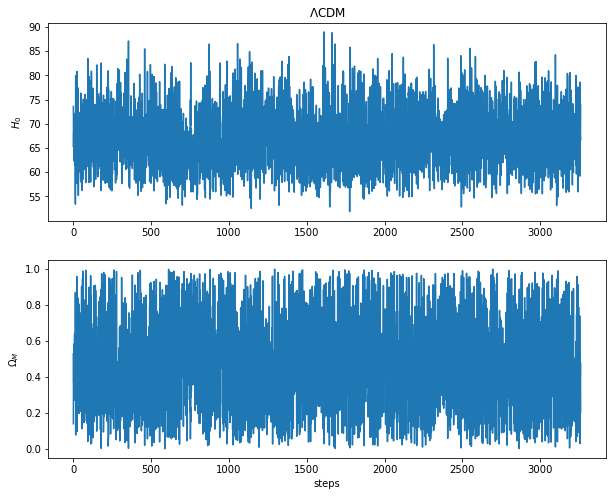

In [114]:
# away a few times this number of steps as “burn-in” ; thin by about half the autocorrelation time
chain_LCDM_emcee = sampler_LCDM_emcee.get_chain(flat=True,thin=15,discard=100)
print(chain_LCDM_emcee.shape)

#plot the chain
labels_LCDM = np.array(['$H_0$','$\Omega_M$'])

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,8))
for i in range(chain_LCDM_emcee.shape[1]):
    ax = ax.ravel()
    ax[i].plot(chain_LCDM_emcee[:,i])
    ax[i].set_ylabel(labels_LCDM[i])
    
plt.xlabel('steps')
ax[0].set_title('$\Lambda$CDM')

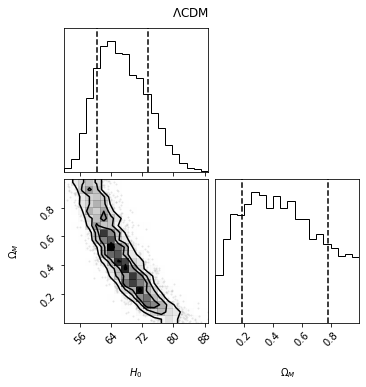

In [469]:
fig = corner.corner(chain_LCDM_emcee, labels=labels_LCDM,quantiles=(0.16, 0.84));
_ = fig.suptitle("$\Lambda$CDM")

In [115]:
from IPython.display import display, Math

params_fit_LCDM = np.zeros(2)

for i in range(2):
    mcmc = np.percentile(chain_LCDM_emcee[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_LCDM[i])
    display(Math(txt))
    params_fit_LCDM[i] = mcmc[1] 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

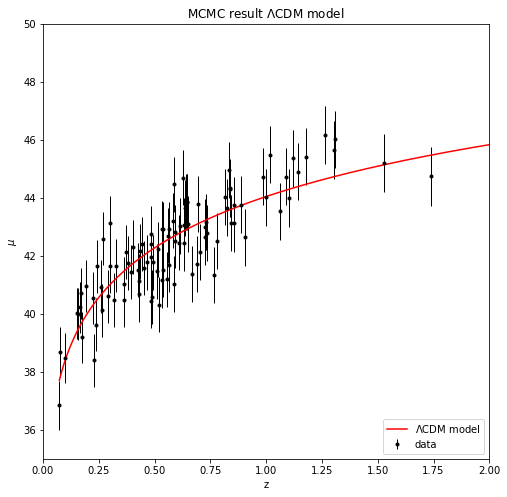

In [116]:
fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0],dist_mod_LCDM(params_fit_LCDM,X_grid[:,0]),color='red',label='$\Lambda$CDM model')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('MCMC result $\Lambda$CDM model')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

#### Matter-only

In [117]:
def Prior_M(params):
    # uniform priors on both the parameters
    prior_H0 = scipy.stats.uniform(0,200).pdf(params)
    
    return prior_H0

def logL_M(params,data,model):
    # load data
    x,y,y_err = data
    
    # fit the model
    y_fit = model(params,x)
    
    # compute the Likelihood
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, y_err))

def log_posterior_M(params,data,model):
     # compute the log-prior
    log_prior = np.log(Prior_M(params))
    
    # put control on the result of the prior
    if not np.isfinite(log_prior):
        return -np.inf
    else:
        return logL_M(params,data,model) + log_prior

In [118]:
# run an MCMC with emcee:
data_fit = np.array([z_sample, mu_sample, dmu])

# prepare the MCMC:
ndim = 1  # number of parameters in the model
nwalkers = 5 # number of MCMC walkers
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize parameters 
np.random.seed(0)
starting_guesses = np.array([70])+1e-3*np.random.randn(nwalkers, ndim)

# run the MCMC: 
sampler_Monly_emcee = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_M, args=(data_fit,dist_mod_Matter))
sampler_Monly_emcee.run_mcmc(starting_guesses, nsteps,progress=True)

100%|██████████| 5000/5000 [06:50<00:00, 12.17it/s]


State([[81.890599  ]
 [77.65985479]
 [87.6340826 ]
 [81.22041132]
 [76.5553523 ]], log_prob=[-139.64271274 -140.02114215 -141.31829739 -139.60422733 -140.37773001], blobs=[], random_state=('MT19937', array([1388826384, 1629326739, 2968996716, 1707701531,  718303992,
       1470186091, 1991502086, 2691296980,  237649078, 2087708986,
       1913620422, 2986135312, 4177852430, 3360188269,  243704966,
        695726203, 4283874983, 3862937592, 3766686071, 3866076840,
       2008946072,  169069342,  409305707, 3988610713, 3465976663,
       2739106991,  853181392, 1115577896, 2767995655, 3710497098,
       2904766575, 2576641824, 1218776108, 3752641727,  228875423,
       4134374936, 2035552079,  517692987, 1559227059, 2290510852,
       3112024714, 2764586994, 2844514890, 2006868467, 4140586252,
       1515766955, 2679502528, 3152553169, 2268040363,  934713763,
       1053060779, 2704468853, 2224009100, 4267020331, 2606865007,
        409253029, 2030821896,  475293765, 1352860973, 26189572

In [119]:
# get the autocorrelation time to determine the burn-in
tau = sampler_Monly_emcee.get_autocorr_time()
print(tau)

[27.03868995]


(1650, 1)


Text(0.5, 1.0, 'Matter only')

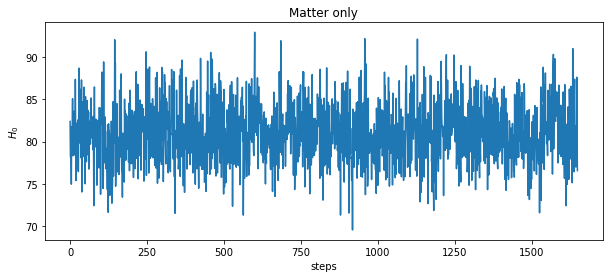

In [121]:
# away a few times this number of steps as “burn-in” ; thin by about half the autocorrelation time
chain_Monly_emcee = sampler_Monly_emcee.get_chain(flat=True,thin=15,discard=50)
print(chain_Monly_emcee.shape)

#plot the chain
labels_M = np.array(['$H_0$'])

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,4))

plt.plot(chain_Monly_emcee[:,0])
plt.ylabel(labels_M[0])   
plt.xlabel('steps')
plt.title('Matter only')

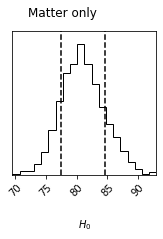

In [122]:
fig = corner.corner(chain_Monly_emcee, labels=labels_M,quantiles=(0.16, 0.84));
_ = fig.suptitle("Matter only")

In [123]:
from IPython.display import display, Math

params_fit_Monly = 0

for i in range(ndim):
    mcmc = np.percentile(chain_Monly_emcee[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_M[i])
    display(Math(txt))
    params_fit_Monly = mcmc[1]
    
    

<IPython.core.display.Math object>

In [144]:
np.array([params_fit_Monly])[0]

80.83772557162145

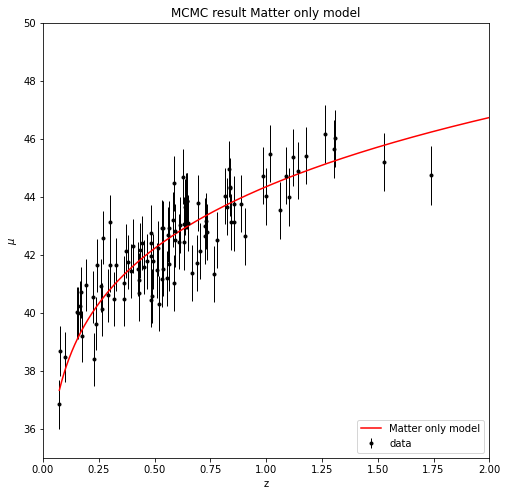

In [145]:
fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0],dist_mod_Matter(np.array([params_fit_Monly]),X_grid[:,0]),color='red',label='Matter only model')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('MCMC result Matter only model')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### Nested sampling

#### Lambda-CDM

In [127]:
def prior_trans_nested(params):
    prior_H0 = scipy.stats.uniform(0,200).ppf(params[0])
    prior_Omega_M = scipy.stats.uniform(0,1).ppf(params[1])
    
    if not np.isfinite(np.array([prior_H0,prior_Omega_M]).any()):
        return -np.inf
    else:
        return np.array([prior_H0,prior_Omega_M])
    
# log-Likelihood:
def logL_nested(params):
    """Gaussian log-likelihood of the model"""
    model=dist_mod_LCDM
    
    # load the data
    x,y,err_y = np.array([z_sample, mu_sample, dmu])
    
    # apply the model
    y_fit = model(params,x)
    
    #print(params)
    #logL_vector.append(sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)))
    
    return sum(-np.log(np.sqrt(2*np.pi)*args[2]) + scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))


In [128]:
# "Static" nested sampling.
ndim = 2

sampler_LCDM = dynesty.NestedSampler(logL_nested, prior_trans_nested, ndim)
sampler_LCDM.run_nested()
sresults_LCDM = sampler_LCDM.results

2240it [04:48,  7.77it/s, +500 | bound: 2 | nc: 1 | ncall: 19578 | eff(%): 14.362 | loglstar:   -inf < -219.242 <    inf | logz: -222.867 +/-  0.068 | dlogz:  0.001 >  0.509]


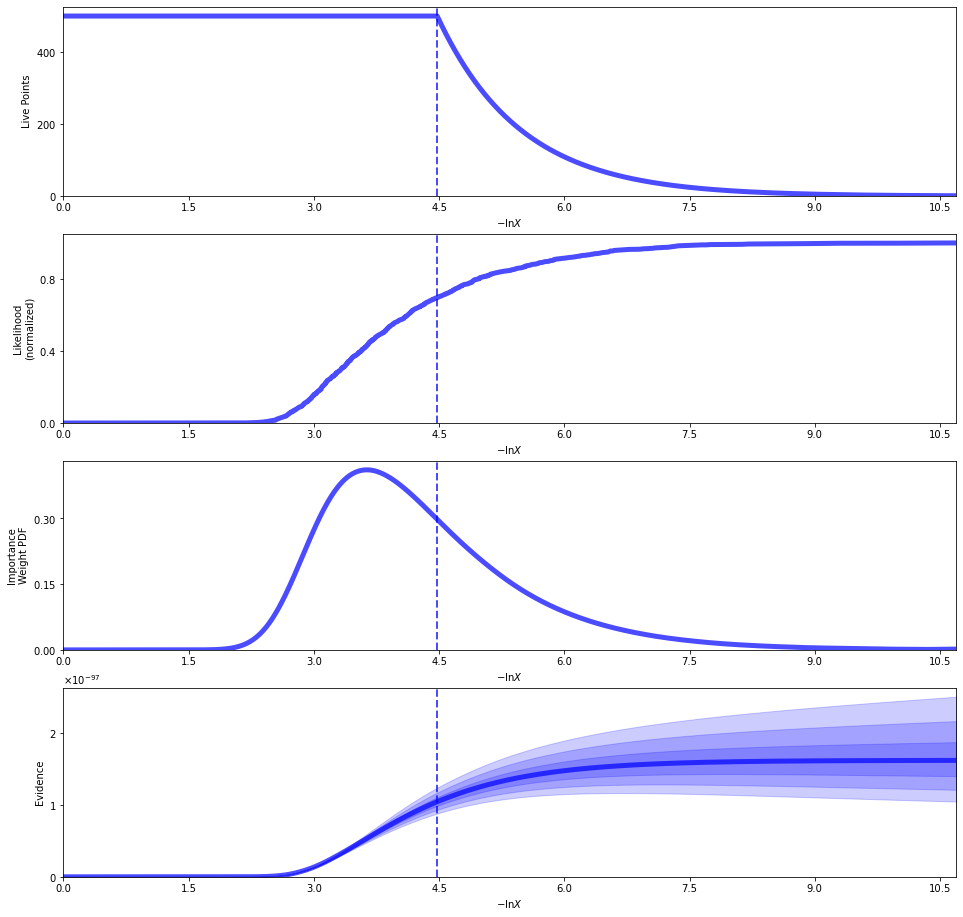

In [130]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(sresults_LCDM)

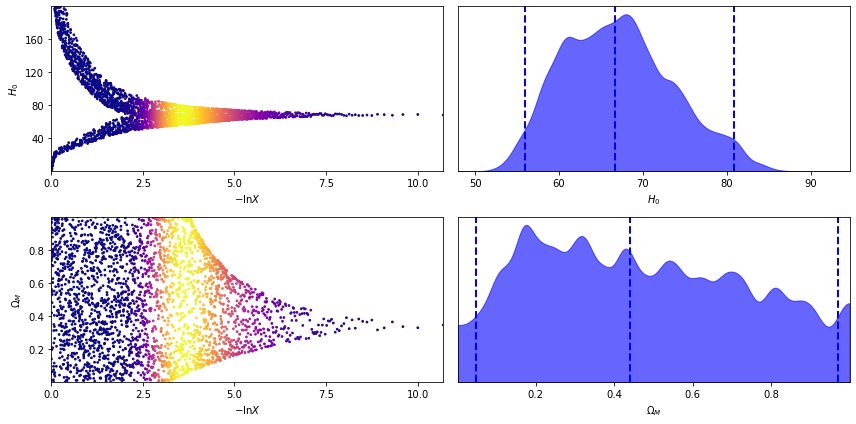

In [131]:
tfig, taxes = dyplot.traceplot(sresults_LCDM,labels=labels_LCDM)
tfig.tight_layout()

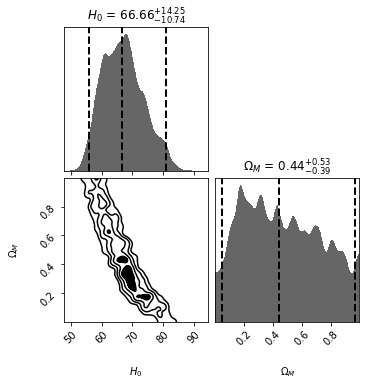

In [132]:
cfig, caxes = dyplot.cornerplot(sresults_LCDM,labels=labels_LCDM,show_titles=True)

In [147]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples_LCDM = sresults_LCDM.samples
weights_LCDM = np.exp(sresults_LCDM.logwt - sresults_LCDM.logz[-1])  # normalized weights

# Resample weighted samples:
samples_equal_LCDM = dyfunc.resample_equal(samples_LCDM,weights_LCDM)

evidence_LCDM = sresults_LCDM.logz[-1] #evidence
print("Bayesian evidence for Lambda-CDM model", np.exp(evidence_LCDM))

# Compute 10%-90% quantiles.
quantiles_LCDM = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_LCDM)
             for samps in samples_LCDM.T]
print('68% parameter credible regions are:\n ' + str(quantiles_LCDM) + '\n')

# Compute weighted mean and covariance.
mean_LCDM, cov_LCDM = dyfunc.mean_and_cov(samples_LCDM, weights_LCDM)
print('Mean and covariance of parameters for the L-CDM model are: \n\n' + str(mean_LCDM) + '\n\n' + str(cov_LCDM))

Bayesian evidence for Lambda-CDM model 1.6224622768036666e-97
68% parameter credible regions are:
 [[60.20922900929416, 73.83686328306018], [0.17358164924147979, 0.782672181942434]]

Mean and covariance of parameters for the L-CDM model are: 

[67.01187634  0.46697355]

[[42.66038353 -1.51177968]
 [-1.51177968  0.07013595]]


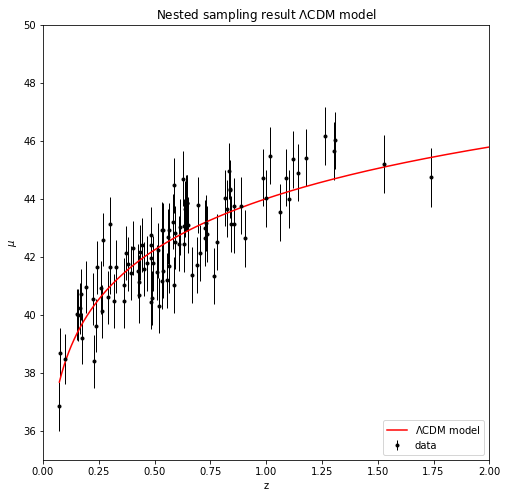

In [148]:
fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0],dist_mod_LCDM(mean_LCDM,X_grid[:,0]),color='red',label='$\Lambda$CDM model')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Nested sampling result $\Lambda$CDM model')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

#### Matter only

In [135]:
def prior_trans_nested_M(params):
    prior_H0 = scipy.stats.uniform(0,200).ppf(params)
    
    if not np.isfinite(prior_H0):
        return -np.inf
    else:
        return np.array(prior_H0)
    
# log-Likelihood:
def logL_nested_M(params):
    """Gaussian log-likelihood of the model"""
    model=dist_mod_Matter
    
    # load the data
    x,y,err_y = np.array([z_sample, mu_sample, dmu])
    
    # apply the model
    y_fit = model(params,x)
    
    #print(params)
    #logL_vector.append(sum(scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y)))
    
    return sum(-np.log(np.sqrt(2*np.pi)*args[2]) + scipy.stats.norm.logpdf(*args) for args in zip(y, y_fit, err_y))


In [146]:
# "Static" nested sampling.
ndim = 1

sampler_M_only = dynesty.NestedSampler(logL_nested_M, prior_trans_nested_M, ndim)
sampler_M_only.run_nested()
sresults_M_only = sampler_M_only.results

2065it [04:37,  7.45it/s, +500 | bound: 1 | nc: 1 | ncall: 19504 | eff(%): 13.497 | loglstar:   -inf < -220.728 <    inf | logz: -223.952 +/-  0.058 | dlogz:  0.001 >  0.509]


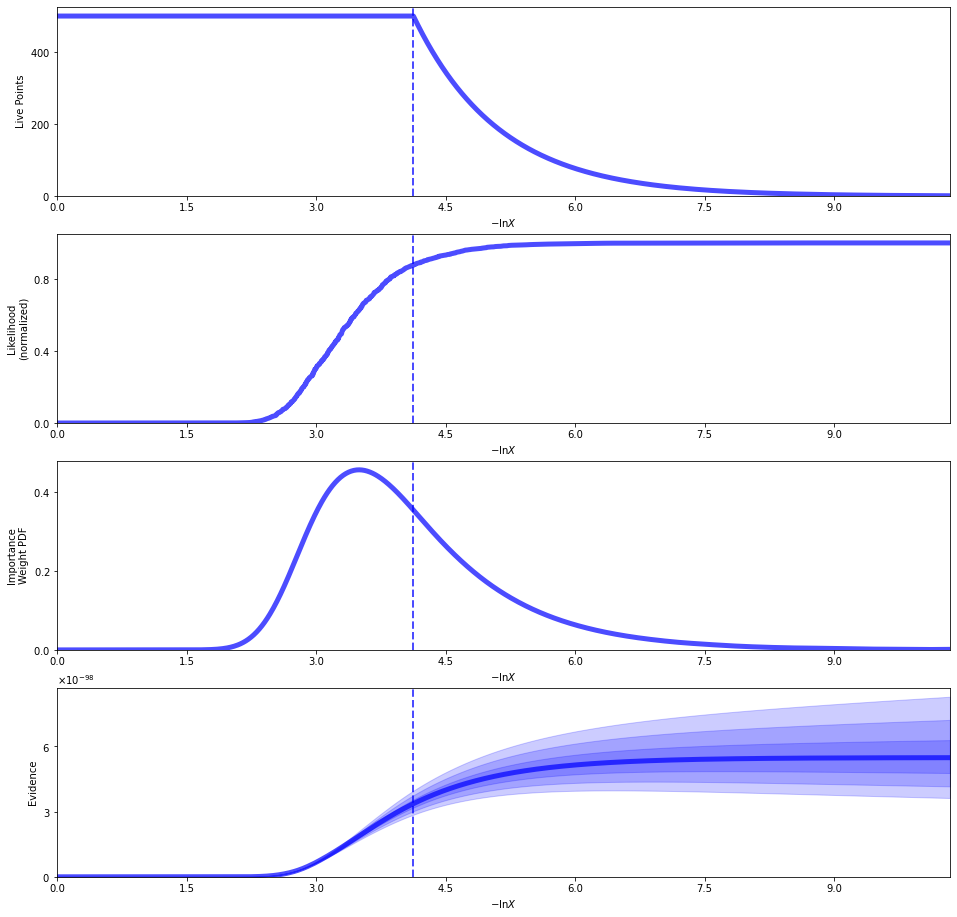

In [149]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(sresults_M_only)

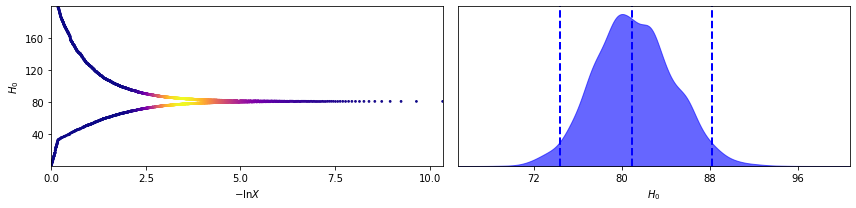

In [150]:
tfig, taxes = dyplot.traceplot(sresults_M_only,labels=labels_M)
tfig.tight_layout()

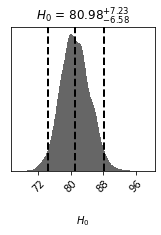

In [151]:
cfig, caxes = dyplot.cornerplot(sresults_M_only,labels=labels_M,show_titles=True)

In [153]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples_M_only = sresults_M_only.samples
weights_M_only = np.exp(sresults_M_only.logwt - sresults_M_only.logz[-1])  # normalized weights

# Resample weighted samples:
samples_equal_M_only = dyfunc.resample_equal(samples_M_only,weights_M_only)

evidence_M_only = sresults_M_only.logz[-1] #evidence
print("Bayesian evidence for Matter-only model", np.exp(evidence_M_only))

# Compute 10%-90% quantiles.
quantiles_M_only = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_M_only)
             for samps in samples_M_only.T]
print('68% parameter credible regions are:\n ' + str(quantiles_M_only) + '\n')

# Compute weighted mean and covariance.
mean_M_only, cov_M_only = dyfunc.mean_and_cov(samples_M_only, weights_M_only)
print('Mean and covariance of parameters for the M-only model are: \n\n' + str(mean_M_only) + '\n\n' + str(cov_M_only))

Bayesian evidence for Matter-only model 5.481348574052105e-98
68% parameter credible regions are:
 [[77.5092498362626, 84.7562969678428]]

Mean and covariance of parameters for the M-only model are: 

[81.088244]

[[12.62237396]]


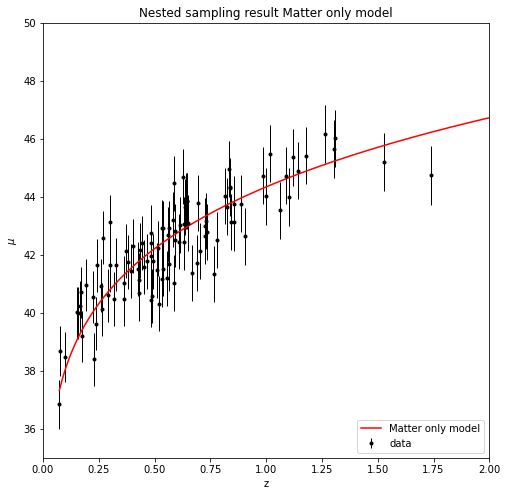

In [154]:
fig = plt.figure(figsize=(8,8))

plt.plot(X_grid[:,0],dist_mod_Matter(mean_M_only,X_grid[:,0]),color='red',label='Matter only model')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Nested sampling result Matter only model')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### Comparing bayesan evidence

In [157]:
LCDM_M_only = np.exp(evidence_LCDM)/np.exp(evidence_M_only)

print('Bayes factor LCDM vs Matter only:',LCDM_M_only)

Bayes factor LCDM vs Matter only: 2.9599691661358


Just strong evidence in favour of the Lambda-CDM model

### Cloning data

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much better.
- Assume a uniform distribution in redshifts between 0 and z.
- Using both the GPR fit and your latest $\Lambda$CDM fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

In [19]:
N = 1000
z_distr = np.linspace(z_sample.min(),z_sample.max(),N) # uniform distribution in z

#### Gaussian cloning: summed kernel

Text(0, 0.5, 'counts')

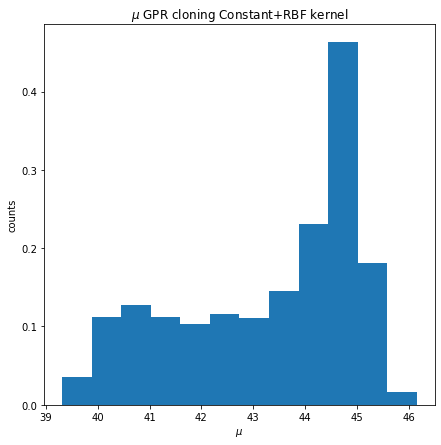

In [159]:
y_cloned_sum, dy_cloned_sum = gp_best_sum.predict(z_distr[:,np.newaxis],return_std=True)

mu_cloned_sum = norm.rvs(y_cloned_sum[:,0], dy_cloned_sum)

fig = plt.figure(figsize=(7,7))
_ = fancyhist(mu_cloned_sum,bins='freedman',density=True)
plt.title('$\mu$ GPR cloning Constant+RBF kernel')
plt.xlabel('$\mu$')
plt.ylabel('counts')

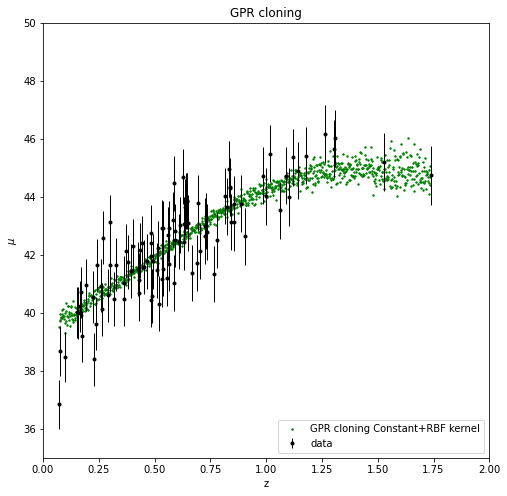

In [160]:
figure = plt.figure(figsize=(8,8))

plt.scatter(z_distr,mu_cloned_sum,color='green',label='GPR cloning Constant+RBF kernel',s=2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('GPR cloning')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [161]:
# comparing the initial distribution with the GPR sampled one:
print(scipy.stats.ks_2samp(mu_sample,mu_cloned_sum))

KstestResult(statistic=0.324, pvalue=5.864273844302659e-09)


#### Gaussian cloning: product kernel


Text(0, 0.5, 'counts')

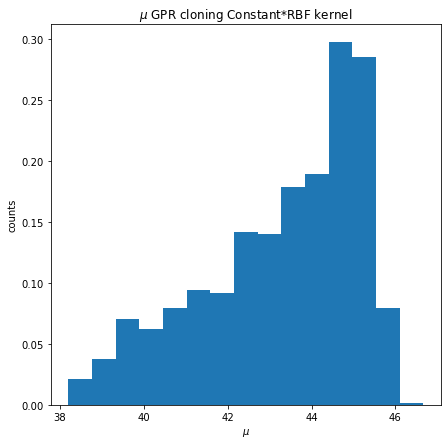

In [20]:
y_cloned_prod, dy_cloned_prod = gp_best_prod.predict(z_distr[:,np.newaxis],return_std=True)

mu_cloned_prod = norm.rvs(y_cloned_prod[:,0], dy_cloned_prod)

fig = plt.figure(figsize=(7,7))
_ = fancyhist(mu_cloned_prod,bins='freedman',density=True)
plt.title('$\mu$ GPR cloning Constant*RBF kernel')
plt.xlabel('$\mu$')
plt.ylabel('counts')

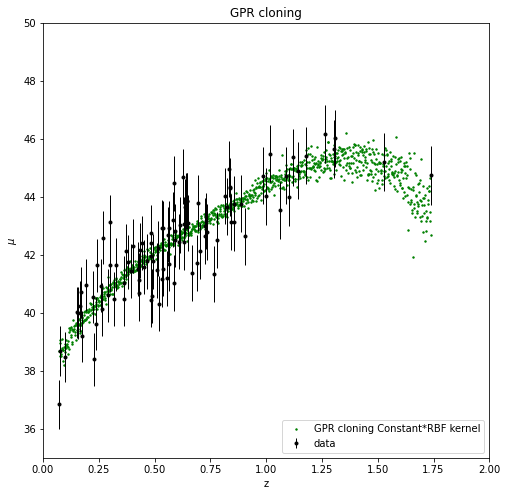

In [21]:
figure = plt.figure(figsize=(8,8))

plt.scatter(z_distr,mu_cloned_prod,color='green',label='GPR cloning Constant*RBF kernel',s=2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('GPR cloning')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [22]:
# comparing the initial distribution with the GPR sampled one:
print(scipy.stats.ks_2samp(mu_sample,mu_cloned_prod))

KstestResult(statistic=0.312, pvalue=2.50662599565743e-08)


#### emcee cloning: LCDM model

Text(0, 0.5, 'counts')

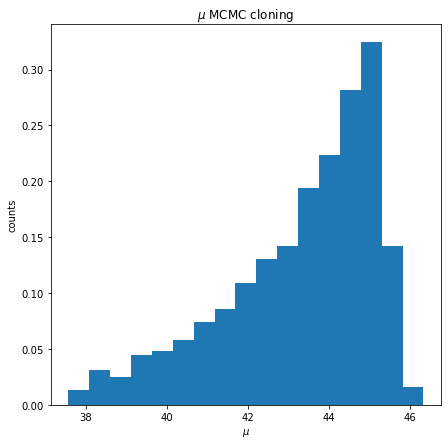

In [165]:
mu_cloned_mc = np.zeros(N)

for i in range(N):
    idx_chain = np.random.choice(np.arange(0,chain_LCDM_emcee.shape[0]))
    mu_cloned_mc[i] = dist_mod_LCDM(chain_LCDM_emcee[idx_chain],z_distr[i])
    

fig = plt.figure(figsize=(7,7))
_ = fancyhist(mu_cloned_mc,bins='freedman',density=True)
plt.title('$\mu$ MCMC cloning')
plt.xlabel('$\mu$')
plt.ylabel('counts')

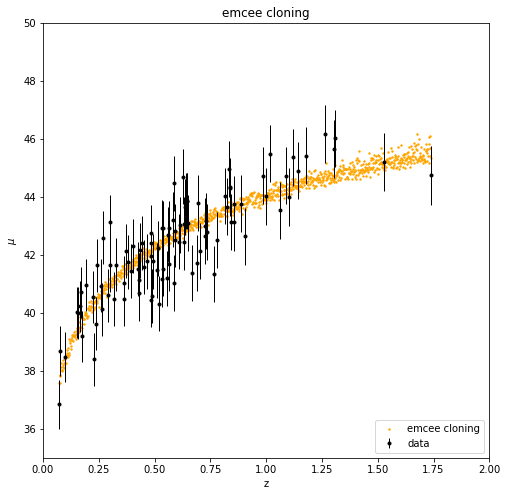

In [166]:
figure = plt.figure(figsize=(8,8))

plt.scatter(z_distr,mu_cloned_mc,color='orange',label='emcee cloning',s=2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('emcee cloning')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [167]:
# comparing the initial distribution with the GPR sampled one:
print(scipy.stats.ks_2samp(mu_sample,mu_cloned_mc))

KstestResult(statistic=0.331, pvalue=2.444568547588233e-09)


#### Nested cloning

Text(0, 0.5, 'counts')

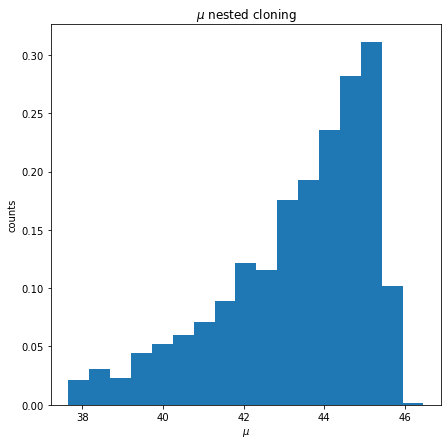

In [170]:
mu_cloned_nested = np.zeros(N)

for i in range(N):
    idx_chain = np.random.choice(np.arange(0,samples_equal_LCDM.shape[0]))
    mu_cloned_nested[i] = dist_mod_LCDM(samples_equal_LCDM[idx_chain],z_distr[i])

fig = plt.figure(figsize=(7,7))
_ = fancyhist(mu_cloned_nested,bins='freedman',density=True)
plt.title('$\mu$ nested cloning')
plt.xlabel('$\mu$')
plt.ylabel('counts')

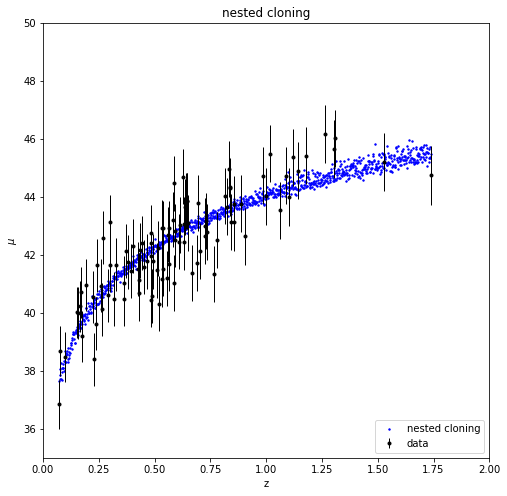

In [171]:
figure = plt.figure(figsize=(8,8))

plt.scatter(z_distr,mu_cloned_nested,color='blue',label='nested cloning',s=2)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='black', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('nested cloning')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [172]:
# comparing the initial distribution with the GPR sampled one:
print(scipy.stats.ks_2samp(mu_sample,mu_cloned_nested))

KstestResult(statistic=0.332, pvalue=2.153715650266008e-09)


# Stuff

1.0


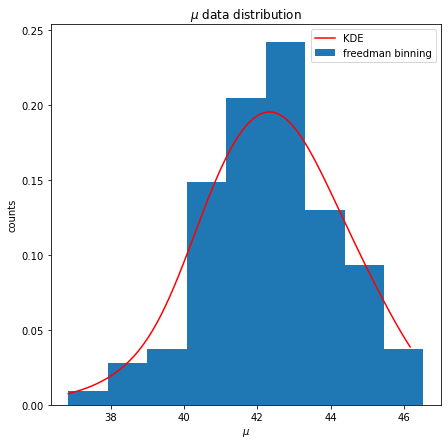

In [378]:
# density estimation cross validation to determine the best bandwith
bw_range = np.linspace(0.01,1,20)
K = 5 # 5 cross validation

grid = GridSearchCV(KernelDensity(), {'bandwidth': bw_range}, cv= K) 
grid.fit(mu_sample[:,np.newaxis]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

# KDE
kde = KernelDensity(bandwidth=h_opt)
kde.fit(mu_sample[:,np.newaxis])

mu_grid = np.linspace(mu_sample.min(),mu_sample.max(),1000)
pdf_kde = np.exp(kde.score_samples(x_grid[:,np.newaxis]))


fig = plt.figure(figsize=(7,7))

_ = fancyhist(mu_sample,bins='freedman',density=True,label='freedman binning')

plt.plot(mu_grid,pdf_kde,label='KDE',color='red')

plt.title('$\mu$ data distribution')
plt.xlabel('$\mu$')
plt.ylabel('counts')
plt.legend()

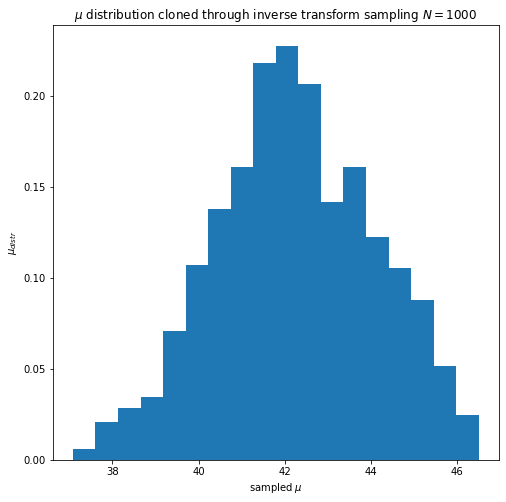

In [379]:
N = len(mu_sample)*10  # 10 times the number of data we have

# cloning by inverse transform
cdf_mu = np.cumsum(pdf_kde)

inv_cum_interp = scipy.interpolate.interp1d(cdf_mu,mu_grid)

eps_sampl = np.random.uniform(min(cdf_mu),max(cdf_mu),N)

# extrapolate directly the sampled z:
mu_sampled_inv_tr = inv_cum_interp(eps_sampl)

fig = plt.figure(figsize=(8,8))

_ = fancyhist(mu_sampled_inv_tr,bins='freedman',density=True)
plt.title(r'$\mu$ distribution cloned through inverse transform sampling $N=%i$'%N)
plt.xlabel(r'sampled $\mu$')
plt.ylabel(r'$\mu_{distr}$')
plt.show()

In [167]:
def mu_z_flatLCDM(params,z):
    H0 = params[0]
    Om_M = params[1]
    
    integrand = 1/(np.sqrt( Om_M*(1+z**3) + (1-Om_M) ))
    
    return 5*np.log10( ( (constants.c/(u.m/u.s))/(H0/1000)) / (10) * (1+z) * np.trapz(y=integrand,x=z) )  

In [190]:
def mu_z_flat_no_Lambda(params,z):
    H0 = params
    Om_M = 1
    
    integrand = 1/(np.sqrt( Om_M*(1+z**3)))
    
    return 5*np.log10( ( (constants.c/(u.m/u.s))/(H0/1000)) / (10) * (1+z) * np.trapz(y=integrand,x=z) )